## Imports

In [ ]:
import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations
from qiskit.circuit.library import RXGate, RYGate, RZGate, RXXGate, RYYGate, RZZGate

from LogicalQ.Logical import LogicalCircuit
from LogicalQ.Library.QECCs import steane_code
from LogicalQ.Execution import execute_circuits
from LogicalQ.Transpilation.UnBox import UnBoxTask

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Underlying code

### Solovay-Kitaev Algorithm

In [3]:
def append_rot_gate(qc, axis = "z", theta = 0, qubit_indices = [0], label = None, return_subcircuit = False, depth = 10, recursion_degree = 1):
    gates = {"x": (RXGate, 1), "y": (RYGate, 1), "z": (RZGate, 1), "xx": (RXXGate, 2), "yy": (RYYGate, 2), "zz": (RZZGate, 2)}
    gate_base, num_target_qubits = gates[axis]
    gate = gate_base(theta)
    
    sub_qc = QuantumCircuit(num_target_qubits)
 
    def apply_Rzz(sub_qc):
        sub_qc.cx(0, 1)
        sub_qc.rz(theta, 1)
        sub_qc.cx(0, 1)
 
    match axis:
        case "xx":
            sub_qc.h([0, 1])
            apply_Rzz(sub_qc)
            sub_qc.h([0, 1])
        case "yy":
            sub_qc.rx(np.pi / 2, [0, 1])
            apply_Rzz(sub_qc)
            sub_qc.rx(-np.pi / 2, [0, 1])
        case "zz":
            apply_Rzz(sub_qc)
        case _:        
            sub_qc.append(gate, qargs = list(range(num_target_qubits)))
    
    basis = ["s", "sdg", "h", "x", "y", "z", "cz"]
    approx = generate_basic_approximations(basis, depth=depth)
    skd = SolovayKitaev(recursion_degree=recursion_degree, basic_approximations=approx)

    discretized_sub_qc = skd(sub_qc)
    box_label = fr"S-K: R$_\text{{{axis}}}$({np.round(theta / np.pi, 2)}$\pi$)" if label == None else label
    if isinstance(qc, LogicalCircuit):
        # with qc.box(label="logical.logicalop.R:{box_label}"):
        for i in range(len(sub_qc.data)):
            circuit_instruction = discretized_sub_qc.data[i]
            qc.append(circuit_instruction)
    elif isinstance(qc, QuantumCircuit):
        qc = discretized_sub_qc
        # sub_gate = discretized_sub_qc.to_gate(label=box_label)
        # qc.append(sub_gate, qubit_indices)
    else:
        raise AssertionError("qc is not a valid QuantumCircuit or LogicalCircuit.")
    
    if return_subcircuit:
        return qc, discretized_sub_qc
    else:
        return qc

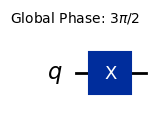

In [4]:
qc = QuantumCircuit(1)
qc = append_rot_gate(qc, "x", np.pi, [0])
qc.draw(output="mpl")

### $\sqrt{X}$ and $\sqrt{X}^\dagger$

In [5]:
def append_sx_gate(qc, qubits, **kwargs):
    append_rot_gate(qc, "x", np.pi/2, qubits, **kwargs)
    return

def append_sxdg_gate(qc, qubits, **kwargs):
    append_rot_gate(qc, "x", -np.pi/2, qubits, **kwargs)
    return qc

## Kogut-Susskind Model

In [6]:
def construct_Usp():
    qc = QuantumCircuit(3)

    qc.h(0)
    qc.x(1)
    qc.x(2)

    qc.cx(0, 1)
    qc.cx(1, 2)

    qc.h(1)

    return qc

def construct_U0(N_s, epsilon, **kwargs):
    qc = QuantumCircuit(3)

    m = N_s//2 - 1
    append_rot_gate(qc, "z", -m * epsilon, [0], **kwargs)
    append_rot_gate(qc, "x", epsilon, [0], **kwargs)
    append_rot_gate(qc, "z", m * epsilon, [0], **kwargs)
    
    return qc

def construct_Ufh1(epsilon, eta, **kwargs):
    qc = QuantumCircuit(3)

    qc.h(1)
    qc.cx(1, 0)
    qc.cx(1, 2)
    
    qc.h(0)
    append_rot_gate(qc, "x", -epsilon * eta/2, [0], **kwargs)
    qc.h(2)

    qc.cx(1, 0)

    qc.h(0)
    qc.z(1)

    qc.s(0)
    qc.cx(1, 2)
    
    append_rot_gate(qc, "x", -epsilon * eta/2, [0], **kwargs)
    qc.h(2)

    qc.s(2)
    qc.cx(1, 2)
    qc.cx(1, 0)

    qc.sdg(0)
    qc.h(1)
    qc.sdg(2)
    
    return qc

def construct_Ufh2(epsilon, eta, **kwargs):
    qc = QuantumCircuit(3)

    append_sxdg_gate(qc, [1], **kwargs)
    qc.s(1)
    qc.cx(0, 1)
    append_sx_gate(qc, [0], **kwargs)
    qc.cx(0, 2)

    append_rot_gate(qc, "x", -epsilon * eta/2, [0], **kwargs)
    append_rot_gate(qc, "y", -epsilon * eta/2, [2], **kwargs)

    qc.cx(0, 2)
    append_sxdg_gate(qc, [0], **kwargs)
    qc.cx(0, 1)
    qc.sdg(1)
    append_sx_gate(qc, [1], **kwargs)
    
    return qc

In [7]:
def construct_KS_timestep(N_s, epsilon, eta, **kwargs):
    qc_U0 = construct_U0(N_s, epsilon, **kwargs)
    qc_Ufh1 = construct_Ufh1(epsilon, eta, **kwargs)
    qc_Ufh2 = construct_Ufh2(epsilon, eta, **kwargs)
    
    qc = QuantumCircuit(3)
    qc.compose(qc_U0, inplace=True)
    # qc.barrier()
    qc.compose(qc_Ufh1, inplace=True)
    # qc.barrier()
    qc.compose(qc_Ufh2, inplace=True)
    # qc.barrier()
    qc.draw("mpl")
    
    return qc

def construct_KS(N_s, T, N_timesteps, eta, **kwargs):
    qc = construct_Usp()
    
    for _ in range(N_timesteps):
        epsilon = T/N_timesteps
        qc_KS_timestep = construct_KS_timestep(N_s, epsilon, eta, **kwargs)
        qc.compose(qc_KS_timestep, inplace=True)

    return qc

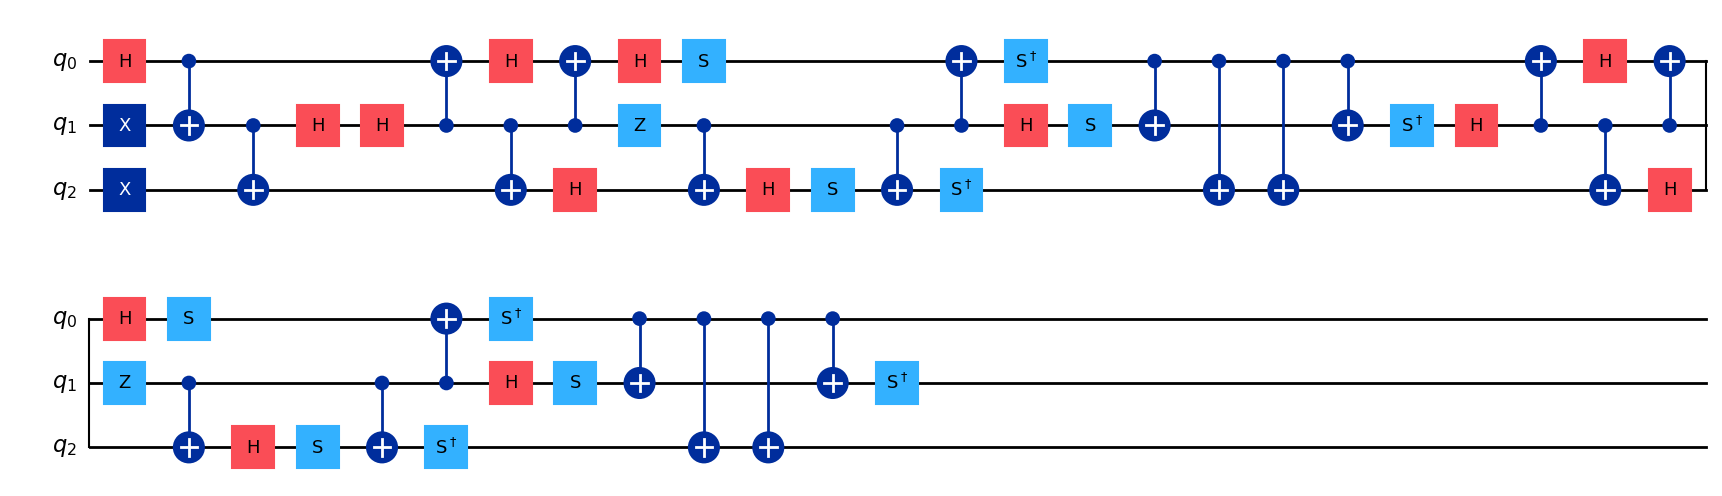

In [8]:
N_s = 2
T = 1
N_timesteps = 2
eta = 1
qc = construct_KS(N_s, T, N_timesteps, eta)
qc.draw("mpl")

### Cost and execute KS quantum circuit

In [9]:
def get_op_count(qc, shots):
    op_counts = qc.count_ops()
    print(f"\nDetailed operation counts: {op_counts}")

    num_measurements = op_counts.get('measure', 0)
    print(f"Number of measurements: {num_measurements}")

    total_ops = qc.size()
    print(f"Total number of operations: {total_ops}")

    cost_hqcs = 5
    for instruction in qc.data:
        if instruction.name in ["measure", "reset"]:
            cost_hqcs += 5 * shots/5000
        elif len(instruction.qubits) == 1:
            cost_hqcs += 10 * shots/5000
        elif len(instruction.qubits) == 1:
            cost_hqcs += 1 * shots/5000
    print(f"Total cost in HQCs: {cost_hqcs}")

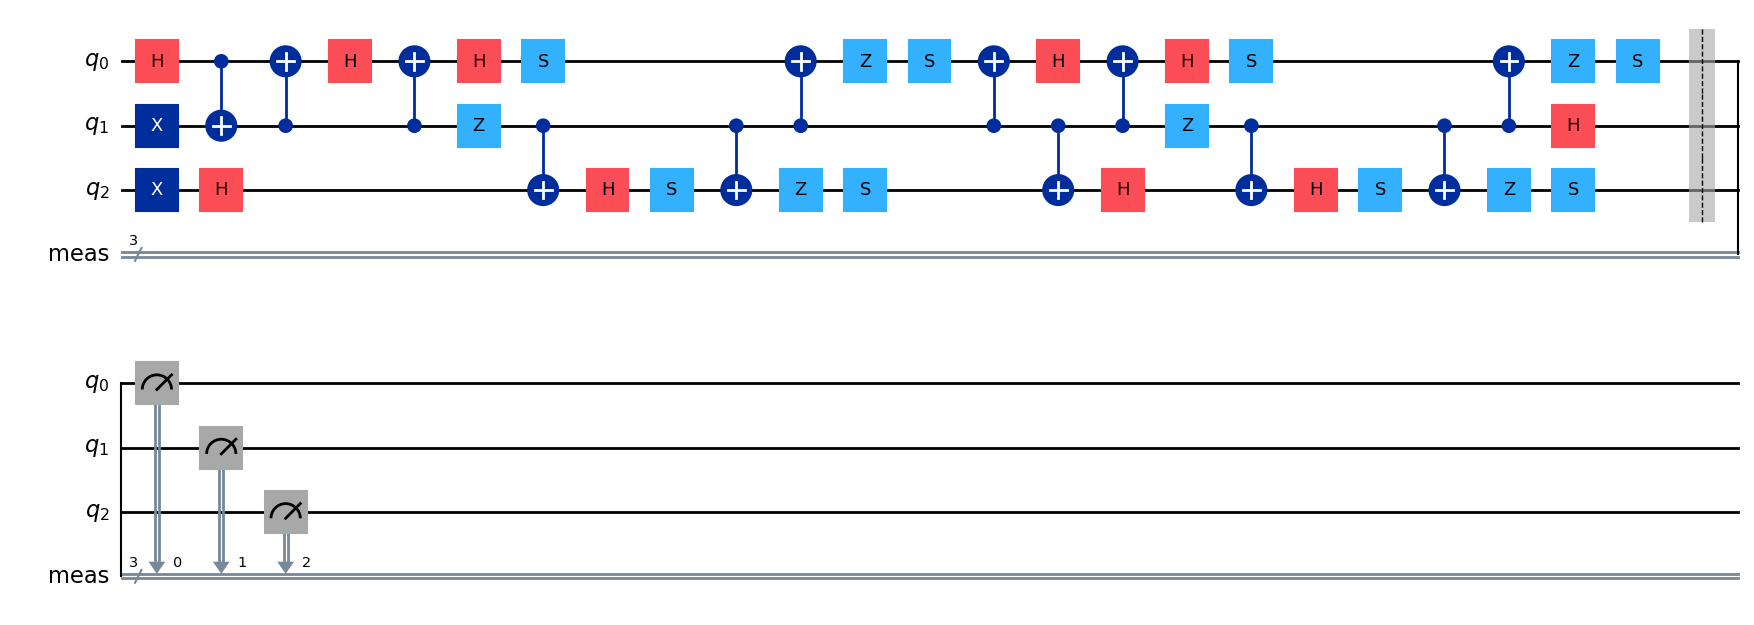

In [10]:
qc_transpiled = transpile(qc, basis_gates=["x", "y", "z", "h", "s", "sdg", "t", "cx"], optimization_level=3)
qc_transpiled.measure_all()
qc_transpiled.draw("mpl")

OrderedDict({'cx': 22, 'h': 14, 's': 6, 'sdg': 6, 'x': 2, 'z': 2})


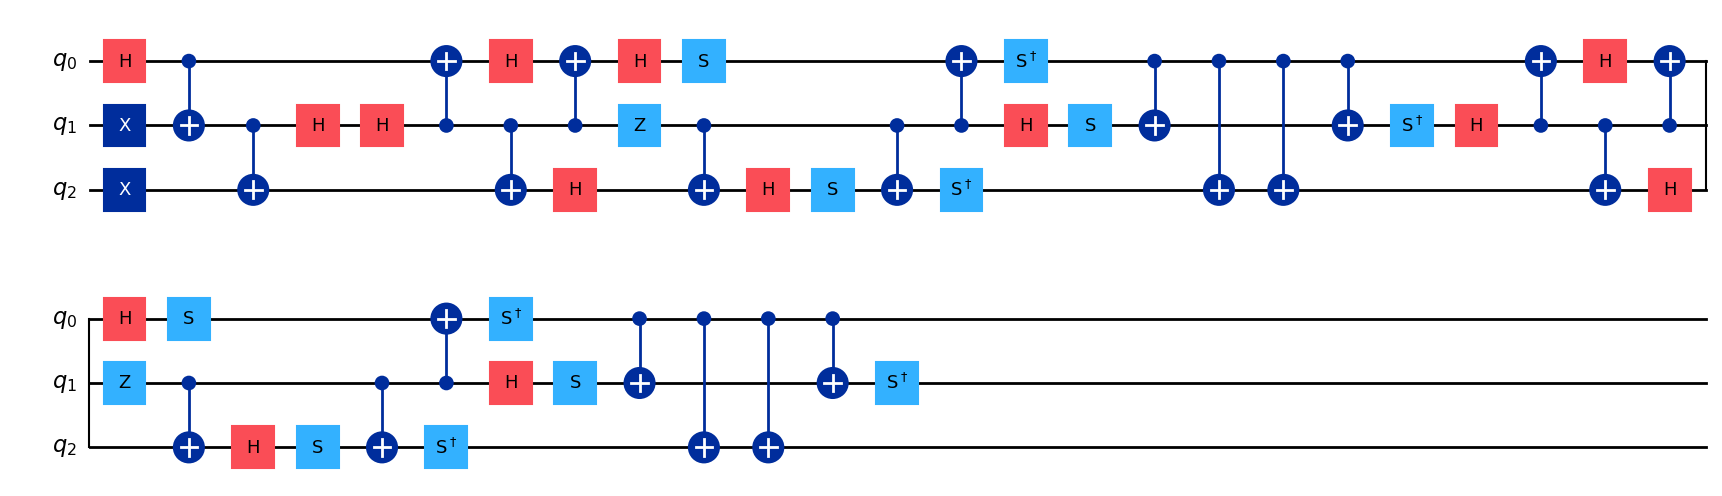

In [11]:
qc_unboxed = qc.copy()
pm = PassManager([UnBoxTask()])
qc_unboxed = pm.run(qc_unboxed)
print(qc_unboxed.count_ops())
while "box" in qc_unboxed.count_ops():
    qc_unboxed = pm.run(qc_unboxed)

qc_unboxed.draw("mpl")

In [12]:
shots = 1E5
get_op_count(qc.decompose(), 1E5)
print()
get_op_count(qc_transpiled, 1.75E5)
print()
get_op_count(qc_unboxed, 1E5)


Detailed operation counts: OrderedDict({'cx': 22, 'u': 16, 'p': 14})
Number of measurements: 0
Total number of operations: 52
Total cost in HQCs: 6005.0


Detailed operation counts: OrderedDict({'cx': 12, 'h': 10, 's': 8, 'z': 6, 'measure': 3, 'x': 2, 'barrier': 1})
Number of measurements: 3
Total number of operations: 41
Total cost in HQCs: 9630.0


Detailed operation counts: OrderedDict({'cx': 22, 'h': 14, 's': 6, 'sdg': 6, 'x': 2, 'z': 2})
Number of measurements: 0
Total number of operations: 52
Total cost in HQCs: 6005.0


In [13]:
result = execute_circuits(
    qc_transpiled,
    backend="quantinuum_H2-2E",
    shots=int(1E4)
)

QuantinuumAPIError: HTTP error attempting: Login.

Server Response: {'error': {'code': 1, 'text': 'An error occurred (InvalidParameterException) when calling the InitiateAuth operation: Missing required parameter USERNAME'}}

In [ ]:
lqc = LogicalCircuit.from_physical_circuit(qc_transpiled, **steane_code)
lqc.draw("mpl")

In [ ]:
result = execute_circuits(
    lqc,
    backend="quantinuum_H2-2",
    shots=int(1E4)
)